### Importing the required Libraries

In [2]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

### Importing the dataset

In [3]:
df=pd.read_csv('D:/Downloads/profiles_2021-11-10.csv')
df.shape

(1209, 23269)

Extracting the features

In [4]:
features={}
prev=df.columns[2].split(".")[0]
counter=0
start_date=df.columns[2].split(".")[-1]
end_date=''
test=[]

for col in df.columns[2:23251]:
    feat=col.split(".")[0]
    date=col.split(".")[-1]
    
    if feat=='conversationsMeta' or feat=='conversations':
        continue
    
    if feat=='appOpens':
        test.append(date)
    
    if feat!=prev:
        features[prev]=[counter,start_date,end_date]
        prev=feat
        start_date=date
    
    end_date=date
    counter+=1
    
df_meta_data=pd.DataFrame(features).T.rename(columns={0:'Count',1:'Start Date',2:'End Date'})
df_meta_data

,Count,Start Date,End Date
appOpens,2324,2014-11-10,2021-04-14
matches,4648,2014-11-10,2021-04-14
messages,9296,2014-11-10,2021-04-14
messagesReceived,11620,2014-11-10,2021-04-14
messagesSent,13944,2014-11-10,2021-04-14
swipeLikes,16268,2014-11-10,2021-04-14
swipePasses,18592,2014-11-10,2021-04-14


Aggregating the features

In [5]:
df_refined=pd.DataFrame()

def aggregate(feat):
    global df_refined
    main_feat=[col for col in df.columns if feat in col]
    df_refined[feat]=df[main_feat].sum(axis=1)
    
    
    if feat=='appOpens':
        df_refined['days_'+feat]=df[main_feat].count(axis=1)
        df_refined['last_Online']=df[main_feat].apply(lambda row: row.last_valid_index(),axis=1).str.split(".",expand=True)[1]
        last_date=datetime.strptime('2014-11-10', "%Y-%m-%d")
        df_refined['last_Online'].fillna(str(last_date).split(' ')[0],inplace=True,axis=0)
        df_refined['active_days']=df_refined['last_Online'].apply(lambda x:str(datetime.strptime(x, "%Y-%m-%d")-last_date)).str.split(' ',expand=True)[0]
        df_refined['active_days']=np.where(df_refined['active_days']=="0:00:00",0,df_refined['active_days'])    

In [6]:
for feat in df_meta_data.T.columns:
    aggregate(feat)
    
for feat in df.columns[23253:]:
    df_refined[feat]=df[feat]

Dealing with Date features

In [23]:
def split_date(feat):
    global df_refined
    df_refined[feat]=df[feat].str.split('T',expand=True)[0]
#Function to add a column to the refined df containing the difference between two dates.
    
def date_diff(feat,new_feat,fillna_date,compare_to_date='',date='',feat_against='',is_date_large=0):
    #(date to convert, name_of_newFeature, default_date, diff_against_feat, diff_against)
    split_date(feat)
    try:
        split_date(compare_to_date)
    except:
        pass
    global df_refined
    
    if len(date)!=0:
        last_date=datetime.strptime(date, "%Y-%m-%d")
        df_refined[feat].fillna(fillna_date,inplace=True,axis=0)
        df_refined[new_feat]=df_refined[feat].apply(lambda x:str(last_date-datetime.strptime(x, "%Y-%m-%d"))).str.split(' ',expand=True)[0]
        df_refined[new_feat]=np.where(df_refined[new_feat]=="0:00:00",0,df_refined[new_feat]) 
        df_refined[new_feat]=df_refined[new_feat].apply(lambda x:int(x))/365.2425
        if is_date_large==1:
            df_refined[new_feat]=df_refined[new_feat]*-1
        
    else:
        df_refined['last_date']=df_refined[compare_to_date].apply(lambda x:str(datetime.strptime(x,"%Y-%m-%d"))).str.split(' ',expand=True)[0]
        
        
        df_refined[feat].fillna(fillna_date,inplace=True,axis=0)
        df_refined[new_feat]=df_refined[feat].apply(lambda x:datetime.strptime(x,"%Y-%m-%d"))-df_refined[compare_to_date].apply(lambda x:datetime.strptime(x,"%Y-%m-%d"))
        df_refined[new_feat]=pd.Series(map(lambda x: int(str(x).split()[0]), df_refined[new_feat]))
        
        df_refined[new_feat]=np.where(df_refined[new_feat]=="0:00:00",0,df_refined[new_feat]) 
        if is_date_large==1:
            df_refined[new_feat]=df_refined[new_feat]*-1
        df_refined[new_feat]=df_refined[new_feat].apply(lambda x:int(x))/365.2425

In [24]:
date_diff('user.birthDate','user.ageLastOnline','1990-01-01','last_Online',is_date_large=1)
date_diff('user.birthDate','user.age','1990-01-01',date='2021-04-14')

In [8]:
import re
def extract_dates(text):
    pattern = r"\b(?:\d{4}-\d{2}-\d{2})\b"
    dates = re.findall(pattern, text)
    dates=[int(x) for x in dates[0].split('-')]
    return dates

def aggregate_months(feat):
    month_trend={}
    for col in df.columns:
        if feat in col:
            dates=extract_dates(col)
            if dates[0] in [2017,2018,2019,2020]:
                if dates[1] not in month_trend:
                    month_trend[dates[1]]=df[col].sum()
                else:
                    month_trend[dates[1]]+=df[col].sum()
    return dict(sorted(month_trend.items()))

In [13]:
pd.DataFrame(df['user.country'].value_counts()).head()

,user.country
CA,27
England,20
Germany,19
United Kingdom,18
France,17


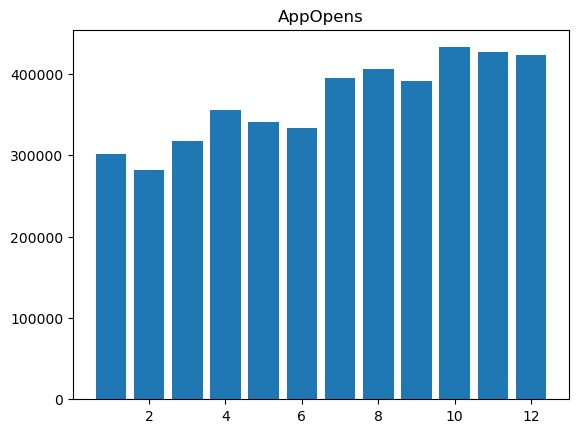

373025.5


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
appOpens=aggregate_months('appOpens')
plt.bar([month for month in appOpens],[appOpens[month] for month in appOpens])
plt.title("AppOpens")
plt.show()
print(np.median(np.array([appOpens[month] for month in appOpens])))

The appOpens increases in the last three months. This can be correlated to the number of Holidays on these months

870.2333333333333


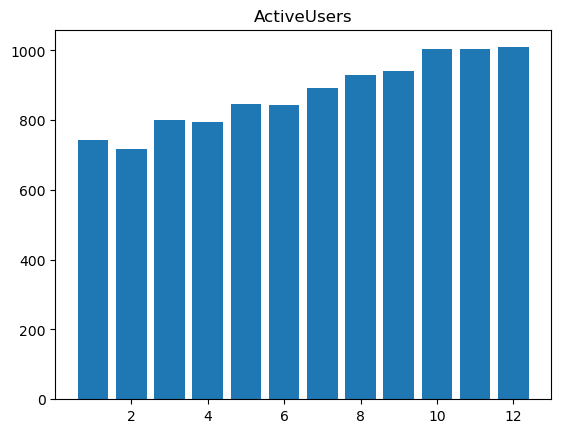

In [10]:
def users_months(feat):
    month_trend={}
    for col in df.columns:
        if feat in col:
            dates=extract_dates(col)
            if dates[0] in [2017,2018,2019,2020]:
                if dates[1] not in month_trend:
                    month_trend[dates[1]]=df[col].count()
                else:
                    month_trend[dates[1]]+=df[col].count()
    for month in month_trend:
        month_trend[month]/=30
    return dict(sorted(month_trend.items()))
appOpens_users=users_months('appOpens')
plt.bar([month for month in appOpens_users],[appOpens_users[month] for month in appOpens_users])
plt.title("ActiveUsers")
print(np.median(np.array([appOpens_users[month] for month in appOpens_users])))

The number of Active users shows a similar trend as AppOpens

Text(0.5, 1.0, 'AppOpens/User')

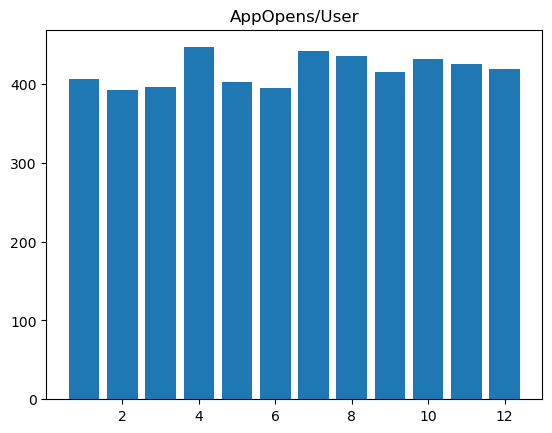

In [12]:
data=[]
for i,j in zip(appOpens,appOpens_users):
    data.append(appOpens[i]/appOpens_users[j])
plt.bar([month for month in range(1,13)], data)
plt.title("AppOpens/User")

Users, on an average are opening the app 13 times a day

42913.5


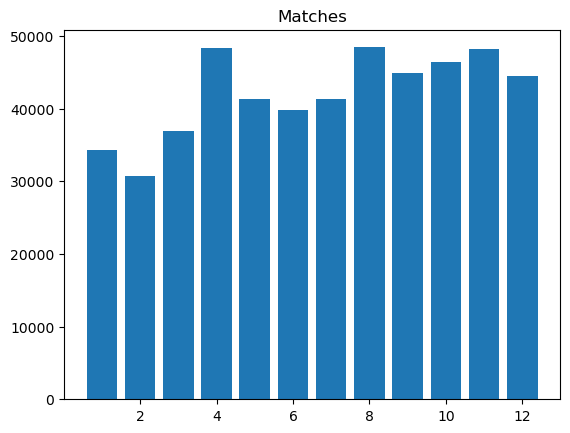

In [14]:
matches=aggregate_months('matches')
plt.bar([month for month in matches],[matches[month] for month in matches])
plt.title("Matches")
print(np.median(np.array([matches[month] for month in matches])))

519528.0


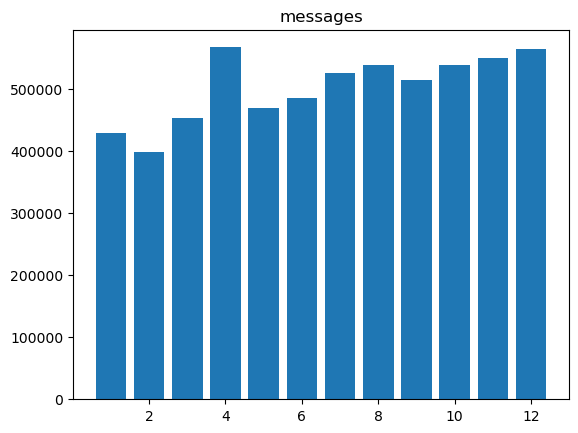

In [16]:
messages=aggregate_months('messages')
plt.bar([month for month in messages],[messages[month] for month in messages])
plt.title("messages")
print(np.median(np.array([messages[month] for month in messages])))

1148658.0


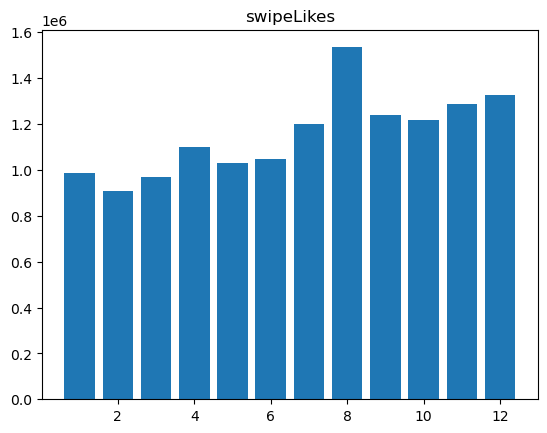

In [17]:
swipeLikes=aggregate_months('swipeLikes')
plt.bar([month for month in swipeLikes],[swipeLikes[month] for month in swipeLikes])
plt.title("swipeLikes")
print(np.median(np.array([swipeLikes[month] for month in swipeLikes])))

2099898.5


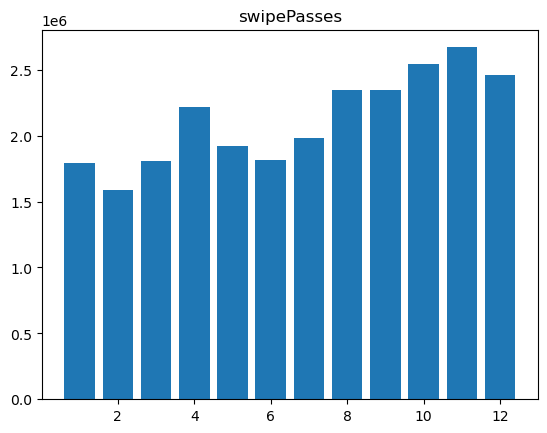

In [18]:
swipePasses=aggregate_months('swipePasses')
plt.bar([month for month in swipePasses],[swipePasses[month] for month in swipePasses])
plt.title("swipePasses")
print(np.median(np.array([swipePasses[month] for month in swipePasses])))

3248556.5


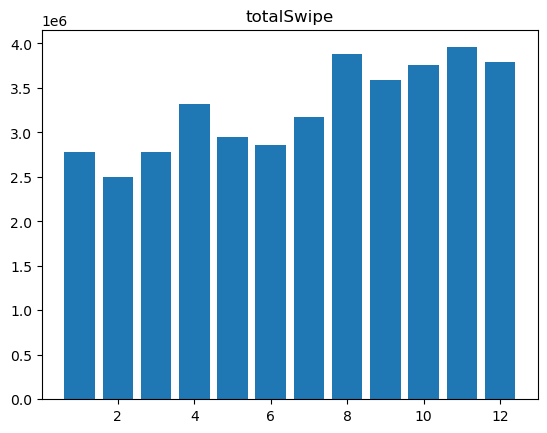

In [19]:
totalSwipe={}
for month in range(1,13):
    totalSwipe[month]=swipeLikes[month]+swipePasses[month]
plt.bar([month for month in totalSwipe],[totalSwipe[month] for month in totalSwipe])
plt.title("totalSwipe")
print(np.median(np.array([totalSwipe[month] for month in totalSwipe])))

11.948088434055006


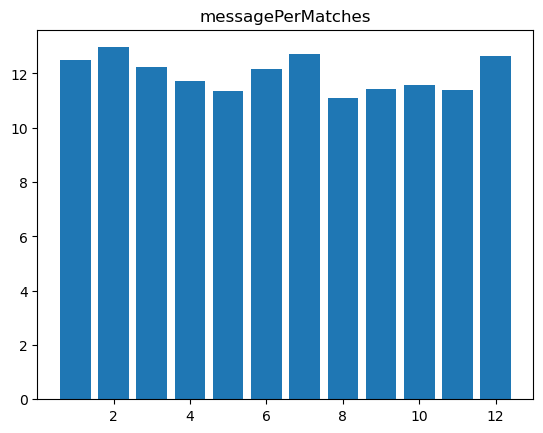

In [20]:
messagePerMatches={}
for month in range(1,13):
    messagePerMatches[month]=messages[month]/matches[month]
plt.bar([month for month in messagePerMatches],[messagePerMatches[month] for month in messagePerMatches])
plt.title("messagePerMatches")
print(np.median(np.array([messagePerMatches[month] for month in messagePerMatches])))

Users are sending around 11 messages/match

80.04197398996433


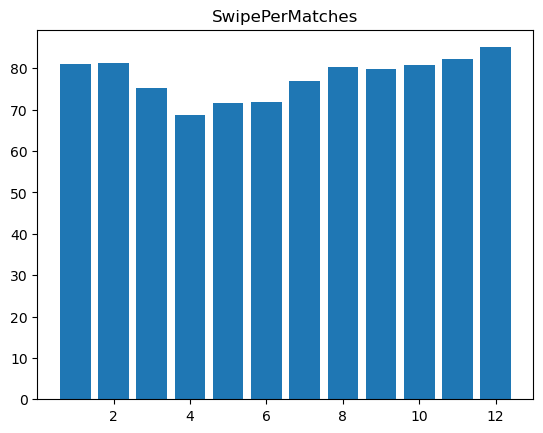

In [21]:
SwipePerMatches={}
for month in range(1,13):
    SwipePerMatches[month]=totalSwipe[month]/matches[month]
plt.bar([month for month in SwipePerMatches],[SwipePerMatches[month] for month in SwipePerMatches])
plt.title("SwipePerMatches")
print(np.median(np.array([SwipePerMatches[month] for month in SwipePerMatches])))

Users are swiping around 80 times/match

(array([233., 356., 239., 147.,  64.,  29.,  23.,   8.,   2.,   2.]),
 array([18.0126902 , 21.6398694 , 25.2670486 , 28.89422781, 32.52140701,
        36.14858621, 39.77576542, 43.40294462, 47.03012382, 50.65730302,
        54.28448223]),
 <BarContainer object of 10 artists>)

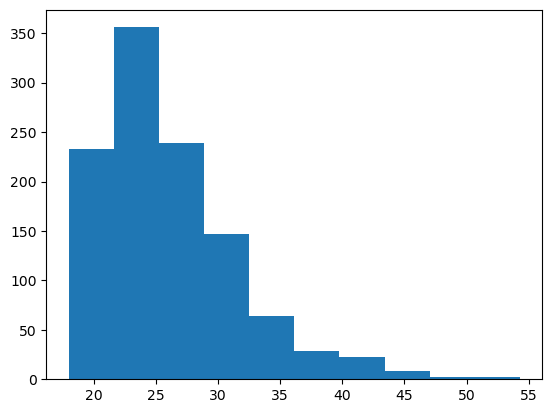

In [25]:
plt.hist(df_refined[(df_refined['user.ageLastOnline']<60)&(df_refined['user.ageLastOnline']>18)]['user.ageLastOnline'])

18703.0 10822.0 0    14843.0
dtype: float64 206.86666666666667


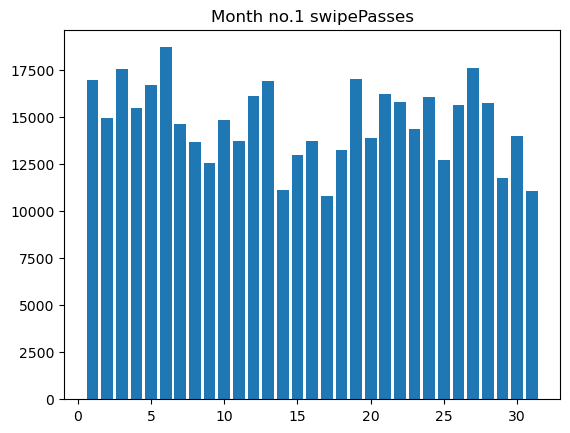

In [32]:
def monthwise(month,feat):
    dic_month={}
    active=0
    for col in df.columns:
        if feat in col:
            date=extract_dates(col)
            if date[1]==month and date[0]==2019:
                if date[2] not in dic_month:
                    dic_month[date[2]]=df[col].sum()
                else:
                    dic_month[date[2]]+=df[col].sum()
                active+=df[col].count()
    plt.bar([day for day in range(1,len(dic_month)+1)], [dic_month[i] for i in dic_month])
    plt.title("Month no."+str(month)+" "+feat)
    print(max([dic_month[i] for i in dic_month]),min([dic_month[i] for i in dic_month]),pd.DataFrame([dic_month[i] for i in dic_month]).median(),active/30)
monthwise(1,'swipePasses')

10810.0 6801.0 0    8051.0
dtype: float64 206.86666666666667


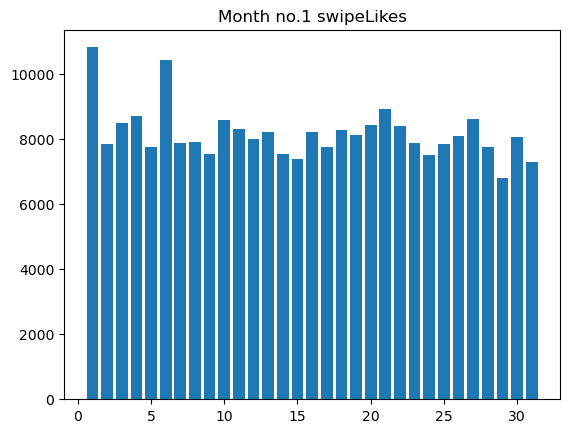

In [33]:
monthwise(1,'swipeLikes')

In [34]:
conversationMeta={}
for col in df.columns:
    if 'conversationsMeta' in col:
        conversationMeta[col]=[df[df['user.gender']=='M'][col].median(),df[df['user.gender']=='F'][col].median(),df[col].median()]
pd.DataFrame(conversationMeta)

,conversationsMeta.averageConversationLength,conversationsMeta.averageConversationLengthInDays,conversationsMeta.longestConversation,conversationsMeta.longestConversationInDays,conversationsMeta.medianConversationLength,conversationsMeta.medianConversationLengthInDays,conversationsMeta.nrOfConversations,conversationsMeta.nrOfGhostingsAfterInitialMessage,conversationsMeta.nrOfOneMessageConversations,conversationsMeta.percentOfOneMessageConversations
0,6.303063,1.853807,64.0,29.418472,2.0,0.007541,59.5,2.0,18.0,32.271889
1,7.114283,1.723486,114.5,50.298530,2.0,0.003142,162.5,36.0,31.5,20.630617
2,6.411123,1.832670,69.0,31.957477,2.0,0.006759,67.0,3.0,19.0,30.208333


15161.0 8828.0 0    11938.0
dtype: float64 182.9


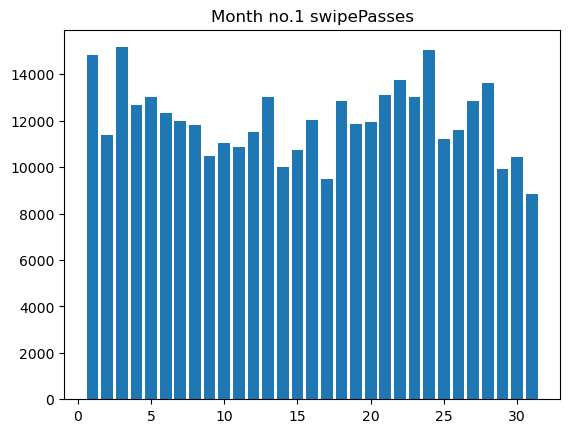

In [37]:
def monthwise_gender(month,feat,gender):
    dic_month={}
    active=0
    for col in df.columns:
        if feat in col:
            date=extract_dates(col)
            if date[1]==month and date[0]==2019:
                if date[2] not in dic_month:
                    dic_month[date[2]]=df[df['user.gender']==gender][col].sum()
                else:
                    dic_month[date[2]]+=df[df['user.gender']==gender][col].sum()
                active+=df[df['user.gender']==gender][col].count()
    plt.bar([day for day in range(1,len(dic_month)+1)], [dic_month[i] for i in dic_month])
    plt.title("Month no."+str(month)+" "+feat)
    print(max([dic_month[i] for i in dic_month]),min([dic_month[i] for i in dic_month]),pd.DataFrame([dic_month[i] for i in dic_month]).median(),active/30)

15161.0 8828.0 0    11938.0
dtype: float64 182.9


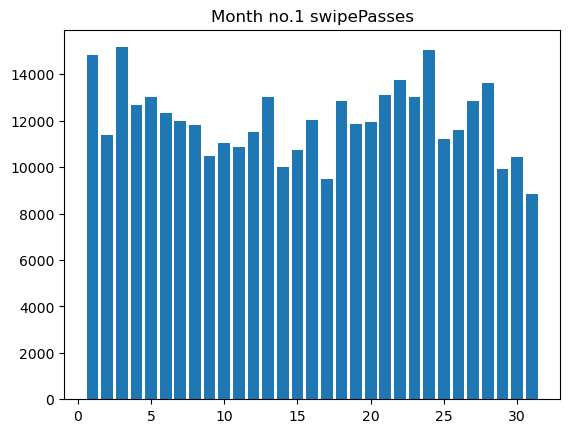

In [38]:
monthwise_gender(1,'swipePasses','M')

10705.0 6669.0 0    7831.0
dtype: float64 182.9


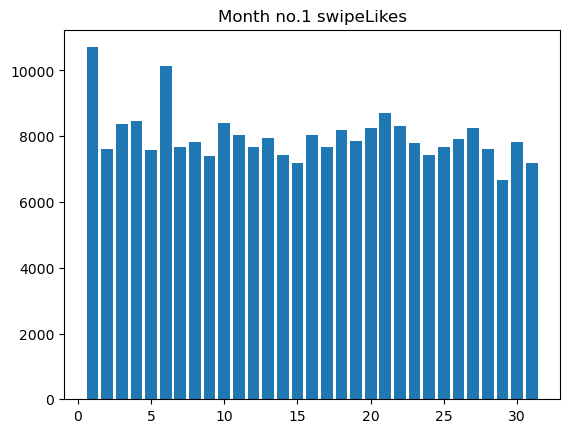

In [39]:
monthwise_gender(1,'swipeLikes','M')

Males are right swipe every 2.5th Profile

6352.0 332.0 0    2248.0
dtype: float64 23.033333333333335


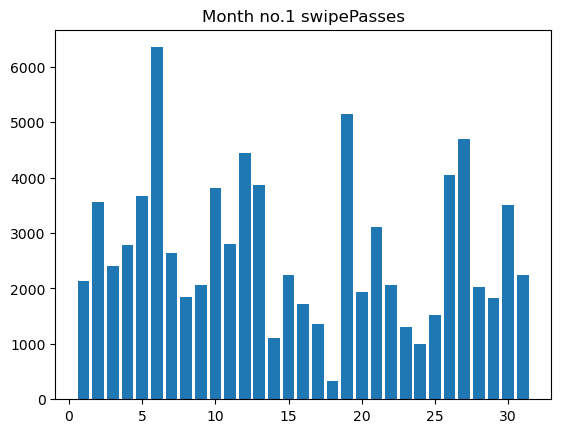

In [40]:
monthwise_gender(1,'swipePasses','F')

291.0 37.0 0    122.0
dtype: float64 23.033333333333335


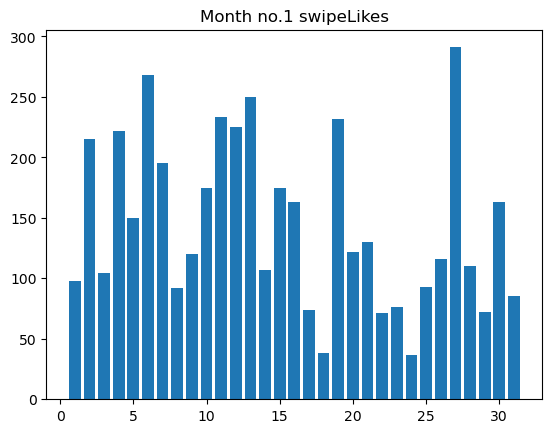

In [41]:
monthwise_gender(1,'swipeLikes','F')

Females right swipe every 20th profile they see